In [1]:
import numpy as np
import tensorflow as tf
import random
import sys
import eli5

import d2d
import importlib
importlib.reload(d2d)
import pandas as pd
import os

2022-11-17 09:09:28.075002: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:


SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

file = "/data/fast0/datasets/Rhone_data_continuous_highpass.h5"

filt = 'Highpass'

history = {}
val_performance = {}
performance = {}

ww = 200
bs = 32

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

input_columns = list(np.arange(0, 2308, 1))


linear_model, lstm_model, dnn_model, df_all_chan, das_data_all, f  = d2d.import_data(filename = file, input_columns = input_columns)

da = df_all_chan.to_numpy()

multi_step_window_shuffled = d2d.WindowGenerator(df_all_chan,
                                                input_width=ww,
                                                label_width=1, 
                                                shift=0,
                                                label_columns=['Discharge'],
                                                input_columns=input_columns,
                                                shuffle=True,
                                                batch_size=bs)

history['lstm_whole_cable'] = d2d.compile_and_fit(lstm_model, multi_step_window_shuffled, learning_rate = 0.001)

val_performance['lstm_whole_cable'] = lstm_model.evaluate(multi_step_window_shuffled.val)
performance['lstm_whole_cable'] = lstm_model.evaluate(multi_step_window_shuffled.test, verbose=0)

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>


2022-11-17 09:09:38.173702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-17 09:09:38.173731: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-17 09:09:38.174059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2308
Epoch 1/1000
7/7 [==============================] - 4s 204ms/step - loss: 0.8887 - mean_absolute_error: 0.7776 - val_loss: 0.7887 - val_mean_absolute_error: 0.6860
Epoch 2/1000
7/7 [==============================] - 1s 116ms/step - loss: 0.5029 - mean_absolute_error: 0.5529 - val_loss: 0.5611 - val_mean_absolute_error: 0.5170
Epoch 3/1000
7/7 [==============================] - 1s 123ms/step - loss: 0.3165 - mean_absolute_error: 0.4408 - val_loss: 0.4277 - val_mean_absolute_error: 0.4563
Epoch 4/1000
7/7 [==============================] - 1s 122ms/step - loss: 0.2538 - mean_absolute_error: 0.3796 - val_loss: 0.4809 - val_mean_absolute_error: 0.4639
Epoch 5/1000
7/7 [==============================] - 1s 122ms/step - loss: 0.2054 - mean_absolute_error: 0.3253 - val_loss: 0.3494 - val_mean_absolute_error: 0.4182
Epoch 6/1000
7/7 [==============================] - 1s 132ms/step - loss: 0.1659 - mean_absolute_error: 0.2844 - val_loss: 0.3188 - val_mean_absolute_error: 0.3800
Epoch 7/100

In [3]:
prediction_set = d2d.WindowGenerator(df_all_chan,
                                    input_width=ww,
                                    label_width=1, 
                                    shift=0,
                                    label_columns=['Discharge'],
                                    input_columns=input_columns,
                                    shuffle=False,
                                    batch_size=bs)

2308


In [4]:
predictions = lstm_model.predict(prediction_set.train).squeeze()

predictions_real = (predictions * prediction_set.dis_std) + prediction_set.dis_mean

7/7 [==============================] - 1s 61ms/step


In [5]:
real_dis = []

for i in prediction_set.train.as_numpy_iterator():
    real_dis.append(i[-1])
    
real_dis = np.asarray(real_dis)
real_dis = real_dis.reshape(real_dis.shape[0] * real_dis.shape[1])

real_dis = (real_dis * prediction_set.dis_std) + prediction_set.dis_mean

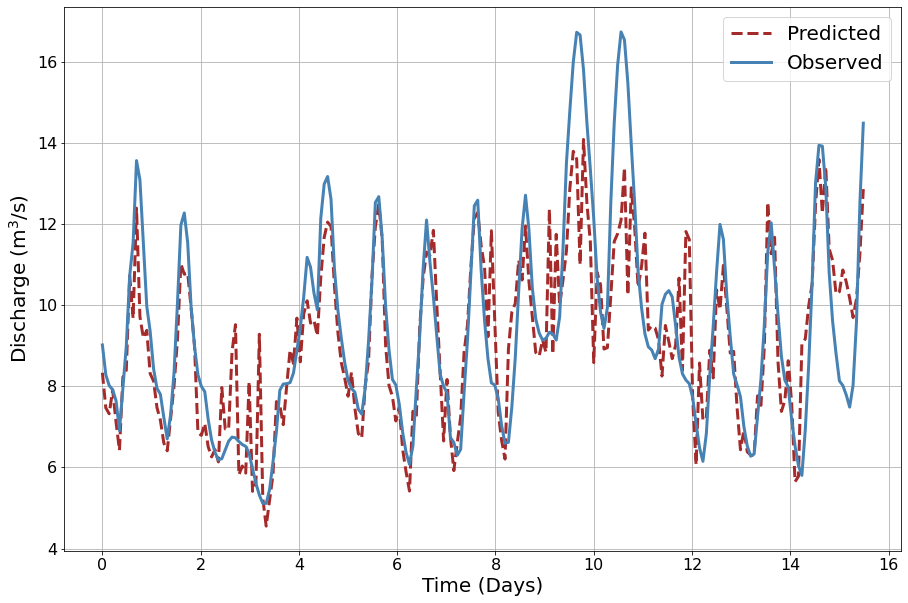

In [11]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize = [15,10])
fig.patch.set_facecolor('white')
factor = 6000/86400 # in days
t = factor*np.arange(len(predictions_real))
ax.plot(t,predictions_real, label = 'Predicted', lw = 3, color = 'brown', linestyle = '--')
ax.plot(t,real_dis, label = 'Observed', lw = 3, color = 'steelblue')

ax.set_ylabel('Discharge (m$^3$/s)', size=20)
ax.set_xlabel('Time (Days)', size=20)

ax.tick_params(labelsize=16)

ax.legend(prop={'size': 20})

#fig.savefig('discharge_train_timeseries.eps', dpi=1200)
plt.grid()
plt.show()